### 03 - New experiments analysis, 20231003

In this notebook we add new columns to the already available spatial ones. We do some analysis around new experiments.

We created the following dictionary that is used to choice what embedding is used in each experiment:

```python
_EMBEDDINGS_FACTORY = {
    "learned_pos_emb_2d": LearnedPositionEmbedding2D,
    "pos_emb_2d": PositionEmbedding2D,
    "rel_pos_emb_2d": RelativePositionEmbedding2D,
}
``````

- exp_005: same as exp_004 but also shutting down the visual position embedding.

- exp_006: same as exp_003 but using pos_emb_2d instead of learned_pos_emb_2d.

- exp_007: same as exp_004 but using pos_emb_2d instead of learned_pos_emb_2d.

- exp_008: same as exp_003 but using relativeposemb2d instead of learned_pos_emb_2d.

- exp_009: same as exp_004 but using relativeposemb2d instead of learned_pos_emb_2d.

- exp_010: same as exp_008 but using batch_size=16 instead of 12.

- exp_011: same as exp_010 but using `num_conv=8` and `mu=0.1`.

In [42]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from torchvision.ops import box_iou

from rec.utils import draw_bounding_boxes

pd.set_option('display.max_colwidth', None)

In [44]:
BASE_PATH = "../code/rec/"

In [3]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def add_pure_spatial(df_valid_results):
    mask_spatial_pure = (
        (df_valid_results.spatial == 1) &
        (df_valid_results.relational == 0) &
        (df_valid_results.ordinal == 0)
    )
    mask_right = (df_valid_results.expr.str.split().apply(lambda l: (l.count("right") > 0)))
    mask_left = (df_valid_results.expr.str.split().apply(lambda l: (l.count("left") > 0)))
    df_valid_results.loc[(mask_spatial_pure & mask_right), "spatial_pure_r"] = True
    df_valid_results.loc[~(mask_spatial_pure & mask_right), "spatial_pure_r"] = False
    df_valid_results.loc[(mask_spatial_pure & mask_left), "spatial_pure_l"] = True
    df_valid_results.loc[~(mask_spatial_pure & mask_left), "spatial_pure_l"] = False
    ambiguous_idx = df_valid_results.query("(spatial_pure_r == True) and spatial_pure_l == True").index
    df_valid_results = df_valid_results.drop(ambiguous_idx).reset_index(drop=True)
    return df_valid_results


def drop_ambiguous_spatial(df_valid_results):
    ambiguous_idx = df_valid_results.query("(spatial_pure_r == True) and spatial_pure_l == True").index
    df_valid_results = df_valid_results.drop(ambiguous_idx).reset_index(drop=True)
    return df_valid_results

def normalize_bbox(bbox, width, height, scalar=500):
     return [
         int(scalar * (bbox[0] / width)),
         int(scalar * (bbox[1] / height)),
         int(scalar * (bbox[2] / width)),
         int(scalar * (bbox[3] / height)),
     ]


def add_normalized_bboxes(df_valid_results, bbox_column_name):
    bboxes_norm = []
    for _, row in df_valid_results.loc[:, ["img_filename", bbox_column_name]].iterrows():
        im = Image.open(f"{BASE_PATH}{row['img_filename']}")
        w, h = im.size
        bboxes_norm.append(normalize_bbox(row[bbox_column_name], w, h))
    df_valid_results.loc[:, f"{bbox_column_name}_norm"] = bboxes_norm
    return df_valid_results


def get_iou_column(df):
    df.loc[:, "bbox_raw"] = df.bbox_raw.apply(lambda v: np.resize(v, (1, 4)))
    df.loc[:, "bbox_pred"] = df.bbox_pred.apply(lambda v: np.resize(v, (1, 4)))
    df.loc[:, "iou"] = df.apply(lambda row: box_iou(torch.from_numpy(row["bbox_pred"]),
                                                    torch.from_numpy(row["bbox_raw"])), axis=1)
    df = df.astype({"iou": float})
    return df

### Read validation data from all available experiments results

In [4]:
exp_list = [
    f"exp_{v}" for v in ["008", "019", "020", "021", "022",
                         "003", "023", "024", "025", "026",
                         "005", "028", "029", "030", "031"]
]

In [5]:
df_metrics_list = []
df_preds_list = []
for exp_folder in exp_list:
    try:
        df = pd.read_csv(f"../models/{exp_folder}/counts_val.csv")
        df.loc[:, "exp_number"] = exp_folder
        df.loc[:, "hits_perc"] = round(df.hits / df.counts * 100, 2)
        df_metrics_list.append(df)
        df_p = pd.read_parquet(f"../models/{exp_folder}/predictions_val.parquet")
        df_p = get_iou_column(df_p)
        df_p.loc[:, "exp_number"] = exp_folder
        df_preds_list.append(df_p)
    except FileNotFoundError:
        print(f"{exp_folder} validation counts are not available at the moment.")
df_exps_counts_val = pd.concat(df_metrics_list, ignore_index=True)
df_preds_val = pd.concat(df_preds_list, ignore_index=True)

In [6]:
df_exps_counts_val.head()

hits  counts     rec_cls exp_number  hits_perc
0  2598.0    4028     spatial    exp_008      64.50
1    36.0      90     ordinal    exp_008      40.00
2   607.0    1205  relational    exp_008      50.37
3  1931.0    2290   intrinsic    exp_008      84.32
4  2600.0    4028     spatial    exp_019      64.55

In [7]:
df_preds_val.head()

bbox_raw  \
0  [[156.0, 169.0, 224.0, 360.0]]   
1     [[0.0, 94.0, 480.0, 360.0]]   
2   [[110.0, 64.0, 296.0, 183.0]]   
3   [[201.0, 49.0, 331.0, 184.0]]   
4   [[176.0, 56.0, 478.0, 195.0]]   

                                       bbox_pred  \
0  [[153.4898, 169.00742, 212.23155, 357.60342]]   
1          [[6.200666, 26.897118, 479.0, 359.0]]   
2   [[78.60463, 6.518875, 299.44653, 171.92131]]   
3   [[169.60495, 81.21001, 317.1008, 180.57022]]   
4      [[210.3464, 7.0640793, 479.0, 195.53151]]   

                                         img_filename                expr  \
0  refer/data/images/saiapr_tc-12/10/images/10890.jpg  person on the left   
1   refer/data/images/saiapr_tc-12/03/images/3593.jpg           the trees   
2   refer/data/images/saiapr_tc-12/03/images/3593.jpg  sky next to clouds   
3   refer/data/images/saiapr_tc-12/03/images/3593.jpg              clouds   
4   refer/data/images/saiapr_tc-12/03/images/3593.jpg            mountain   

   hits  spatial  ordinal  relational  intrinsic       iou exp_number  
0   1.0        1        0           0          0  0.787811    exp_008  
1   1.0        0        0           0          1  0.785991    exp_008  
2   1.0        1        0           1          0  0.520191    exp_008  
3   1.0        0        0           0          1  0.558110    exp_008  
4   1.0        0        0           0          1  0.671470    exp_008

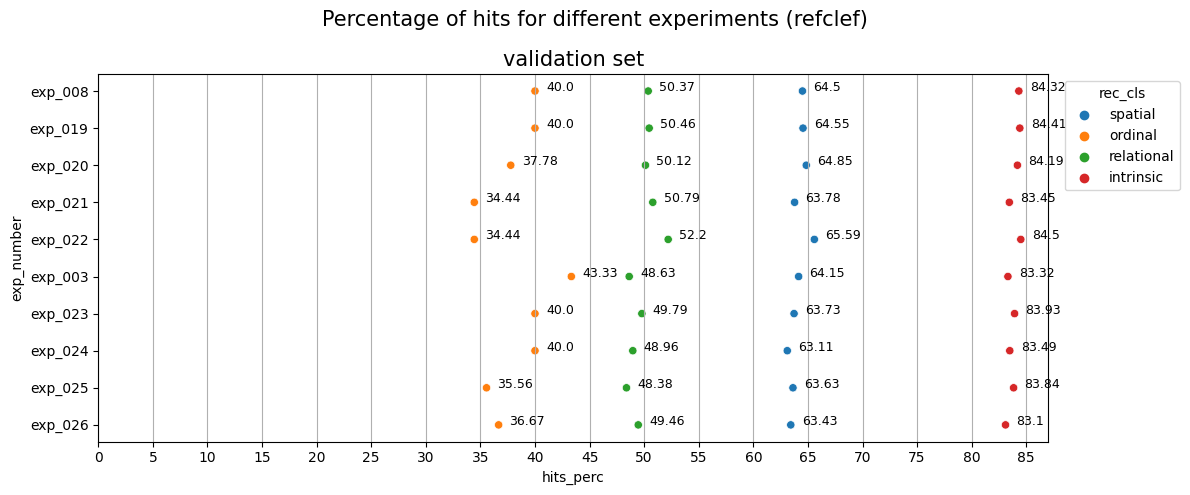

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
lst_exps = exp_list[:10]
df = df_exps_counts_val.query("exp_number in @lst_exps")
fig.suptitle('Percentage of hits for different experiments (refclef)', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

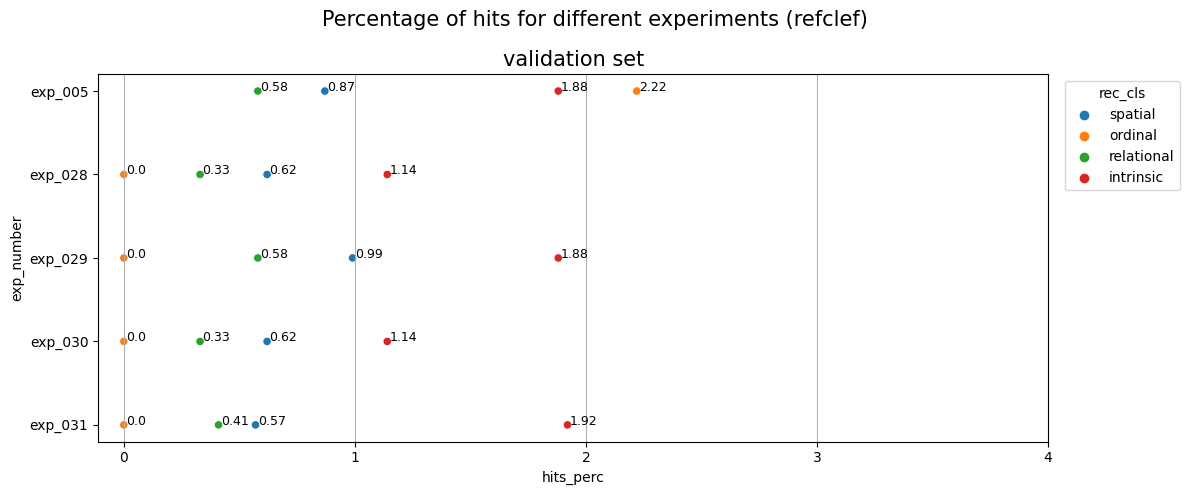

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
lst_exps = exp_list[10:]
df = df_exps_counts_val.query("exp_number in @lst_exps")
fig.suptitle('Percentage of hits for different experiments (refclef)', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 0.01, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 5, 1)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### IOU distribution

In [12]:
df_preds_val.groupby("exp_number").iou.sum().sort_values()

exp_number
exp_028     694.709607
exp_030     694.709607
exp_029     709.268624
exp_005     737.926770
exp_031     742.059156
exp_026    3952.639121
exp_024    3956.278344
exp_025    3975.680406
exp_023    3979.692924
exp_003    3985.210197
exp_021    3985.667715
exp_008    4002.006962
exp_019    4009.468145
exp_020    4016.606689
exp_022    4064.698529
Name: iou, dtype: float64

Let's select the experiments with maximum difference between them.

<AxesSubplot:xlabel='exp_number', ylabel='iou'>

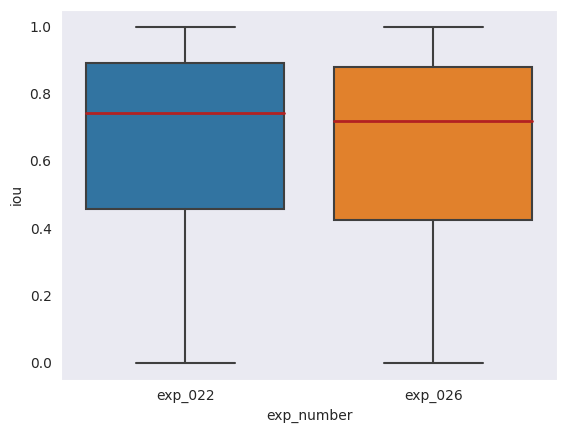

In [112]:
sns.set_style("dark", {'axes.grid' : False, })
sns.boxplot(data=df_preds_val.query("exp_number in ('exp_022', 'exp_026')"),
            x="exp_number", y="iou", medianprops={"color": "firebrick", "linewidth": 2})

We see just a few differences. The median in the exp_022 is higher than exp_026.

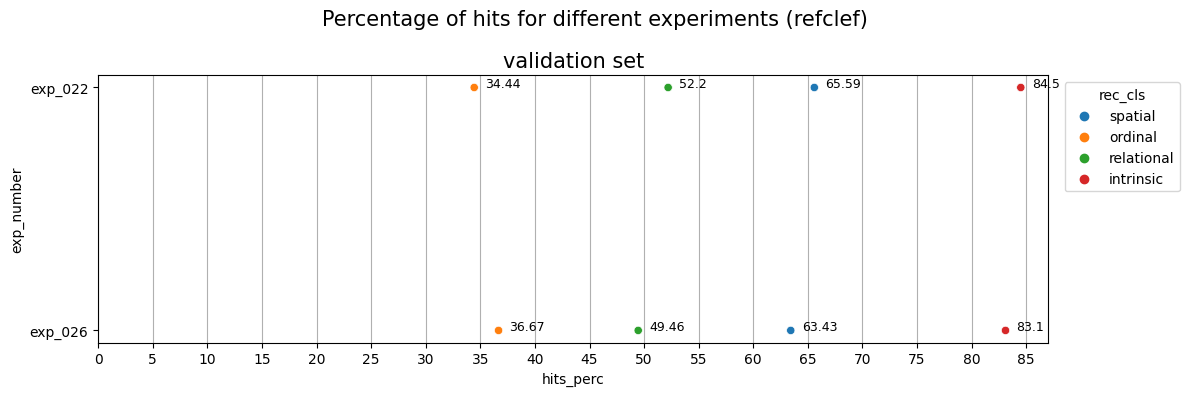

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
lst_exps = ["exp_022", "exp_026"]
df = df_exps_counts_val.query("exp_number in @lst_exps")
fig.suptitle('Percentage of hits for different experiments (refclef)', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

Let's analyze the differences in some samples.

In [26]:
df_preds_val_sub = df_preds_val.query("exp_number in ('exp_022', 'exp_026')").reset_index(drop=True)

In [36]:
df_preds_val_sub = pd.merge(
    df_preds_val.query("exp_number == 'exp_022'").reset_index(drop=True).iloc[:, :-1],
    df_preds_val.query("exp_number == 'exp_026'").reset_index(drop=True).iloc[:, :-1],
    on=['img_filename', 'expr', 'spatial', 'ordinal', 'relational', 'intrinsic'],
    suffixes=["_22", "_26"]
)
df_preds_val_sub = (
    df_preds_val_sub
    .drop(columns=["bbox_raw_22"])
    .rename(columns={"bbox_raw_26": "bbox_raw"})
    .astype({"hits_22": "int", "hits_26": "int"})
    .loc[:, ["img_filename", "bbox_raw", "expr", "spatial",
             "ordinal", "relational", "intrinsic", "hits_22",
             "hits_26", "iou_22", "iou_26", "bbox_pred_22", "bbox_pred_26"]]
)

In [43]:
df_preds_val_sub.head()

img_filename  \
0  refer/data/images/saiapr_tc-12/10/images/10890.jpg   
1   refer/data/images/saiapr_tc-12/03/images/3593.jpg   
2   refer/data/images/saiapr_tc-12/03/images/3593.jpg   
3   refer/data/images/saiapr_tc-12/03/images/3593.jpg   
4   refer/data/images/saiapr_tc-12/03/images/3593.jpg   

                         bbox_raw                expr  spatial  ordinal  \
0  [[156.0, 169.0, 224.0, 360.0]]  person on the left        1        0   
1     [[0.0, 94.0, 480.0, 360.0]]           the trees        0        0   
2   [[110.0, 64.0, 296.0, 183.0]]  sky next to clouds        1        0   
3   [[201.0, 49.0, 331.0, 184.0]]              clouds        0        0   
4   [[176.0, 56.0, 478.0, 195.0]]            mountain        0        0   

   relational  intrinsic  hits_22  hits_26    iou_22    iou_26  \
0           0          0        1        1  0.781094  0.822742   
1           0          1        1        1  0.719651  0.780098   
2           1          0        1        0  0.621565  0.373670   
3           0          1        0        0  0.388568  0.352456   
4           0          1        1        1  0.794188  0.776648   

                                     bbox_pred_22  \
0  [[154.50389, 173.09952, 212.86964, 355.22983]]   
1             [[4.131746, 0.0, 479.0, 355.14322]]   
2   [[86.54511, 29.747314, 289.40497, 173.67107]]   
3      [[196.49837, 29.977425, 479.0, 174.91383]]   
4   [[214.31976, 46.711113, 478.2086, 189.90207]]   

                                      bbox_pred_26  
0   [[152.99171, 171.55185, 216.15022, 356.82693]]  
1           [[6.9311852, 24.768326, 479.0, 359.0]]  
2      [[6.802096, 1.379425, 319.0462, 176.20583]]  
3  [[118.104454, 40.018784, 443.45898, 193.06224]]  
4       [[163.59476, 33.891205, 479.0, 205.25882]]

#### Relational

In [40]:
df_rel_22_better_than_26 = df_preds_val_sub.query("hits_26 == 0 and hits_22 == 1 and relational == 1")

In [41]:
df_rel_22_better_than_26.head()

img_filename  \
2     refer/data/images/saiapr_tc-12/03/images/3593.jpg   
85    refer/data/images/saiapr_tc-12/03/images/3786.jpg   
357  refer/data/images/saiapr_tc-12/11/images/11575.jpg   
360  refer/data/images/saiapr_tc-12/11/images/11575.jpg   
384  refer/data/images/saiapr_tc-12/16/images/16391.jpg   

                           bbox_raw  \
2     [[110.0, 64.0, 296.0, 183.0]]   
85   [[241.0, 288.0, 313.0, 323.0]]   
357    [[111.0, 52.0, 146.0, 73.0]]   
360    [[226.0, 63.0, 254.0, 85.0]]   
384   [[247.0, 96.0, 360.0, 183.0]]   

                                                       expr  spatial  ordinal  \
2                                        sky next to clouds        1        0   
85   small cloud , just to righ of center and at the bottom        1        0   
357                                      helmet on left guy        1        0   
360                     the helmet of the man in the middle        1        0   
384                                  water near man 's back        1        0   

     relational  intrinsic  hits_22  hits_26    iou_22    iou_26  \
2             1          0        1        0  0.621565  0.373670   
85            1          0        1        0  0.674378  0.000000   
357           1          0        1        0  0.581531  0.379741   
360           1          0        1        0  0.519771  0.444946   
384           1          0        1        0  0.695307  0.000000   

                                       bbox_pred_22  \
2     [[86.54511, 29.747314, 289.40497, 173.67107]]   
85     [[246.5018, 286.7705, 320.89127, 330.57608]]   
357   [[106.792404, 45.37783, 146.1352, 77.503265]]   
360  [[224.40211, 65.104774, 260.02374, 93.537476]]   
384    [[225.33643, 97.08532, 350.2535, 174.59425]]   

                                      bbox_pred_26  
2      [[6.802096, 1.379425, 319.0462, 176.20583]]  
85      [[288.27158, 125.19203, 479.0, 212.30734]]  
357  [[103.08902, 50.757828, 142.06421, 92.71341]]  
360  [[217.25813, 65.79386, 248.49496, 90.989685]]  
384       [[0.0, 97.182335, 168.95235, 185.25452]]

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
lady in white shirt


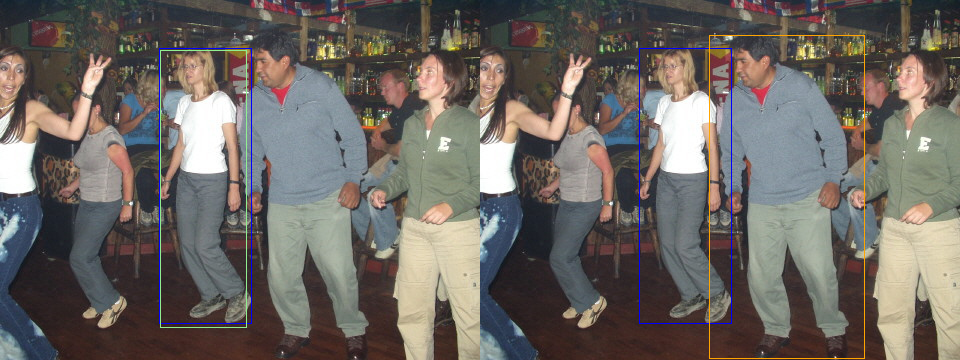

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
fence above kneeling red girl


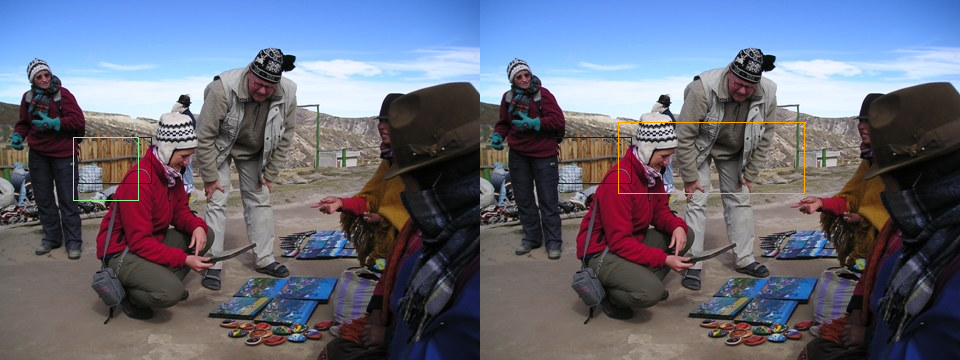

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
person sitting reaching for the person in blue jacket


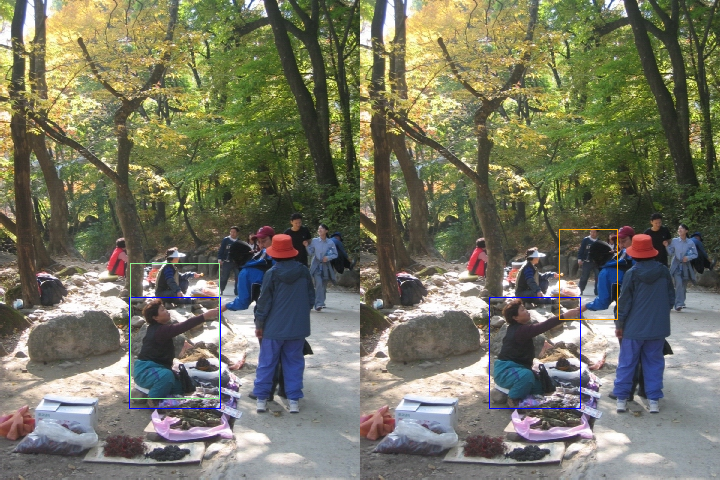

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
hat of girl in left


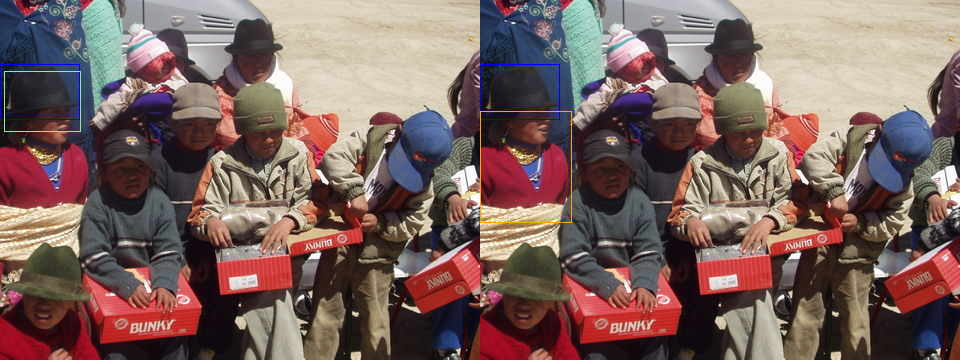

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
pavement front of bus


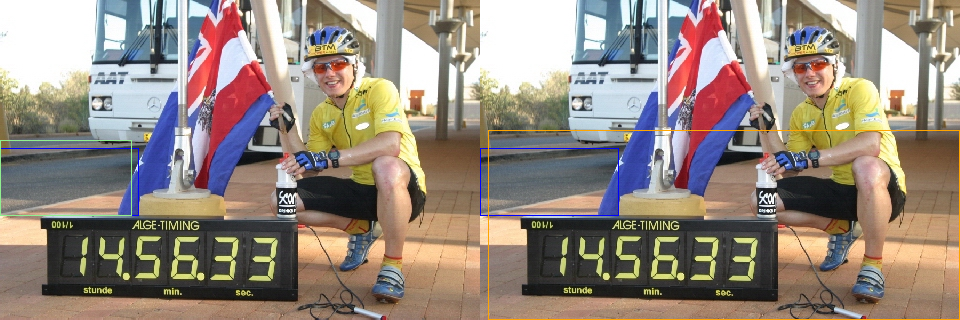

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
the baby to the right of the mamas beak


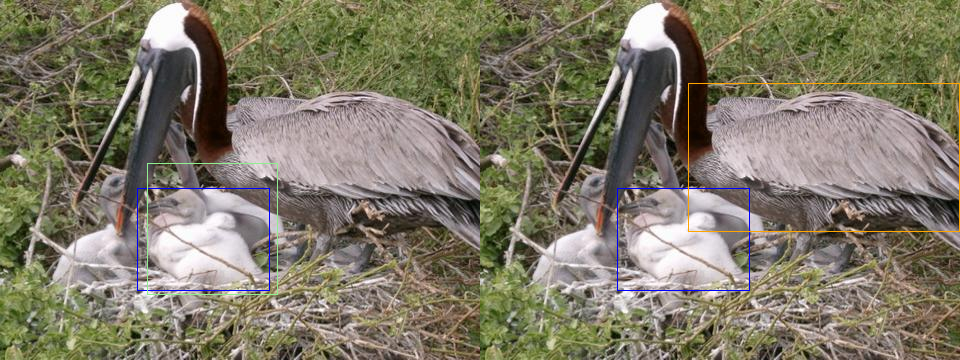

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
archway of the bridge


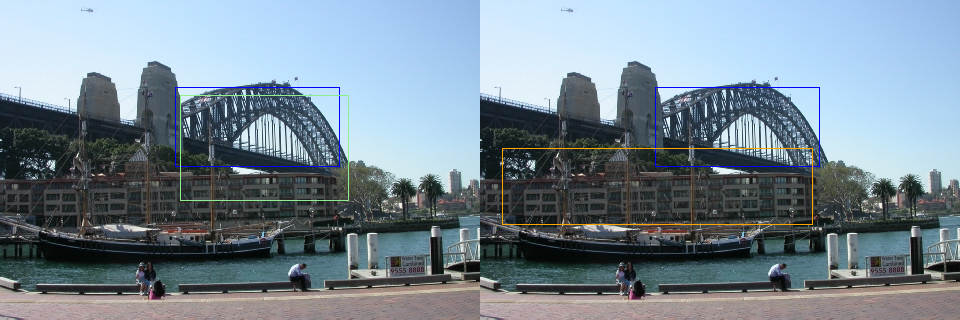

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
the sign to the right of the peoples butts


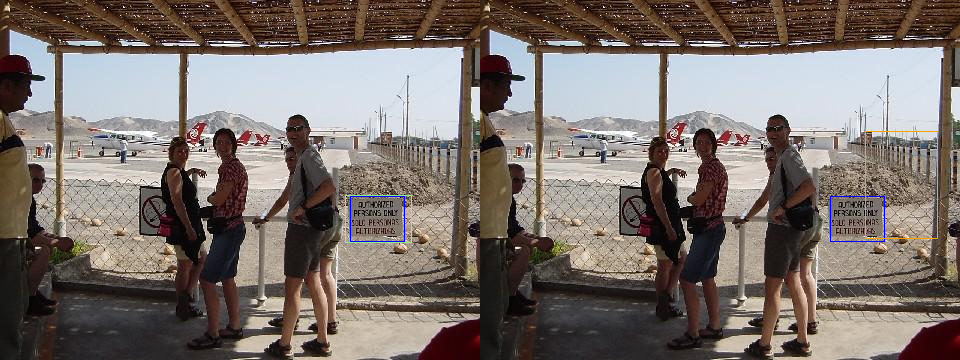

In [63]:
df_sample_cls = df_rel_22_better_than_26.query("0 < iou_26 <= 0.1")
df_sample_cls = df_sample_cls.sample(min(10, df_sample_cls.shape[0]), random_state=42)
for _, row in df_sample_cls.loc[:, ["bbox_raw", "bbox_pred_22", "bbox_pred_26", "img_filename", "expr"]].iterrows():
    im = Image.open(f"{BASE_PATH}{row['img_filename']}")
    im = draw_bounding_boxes(im, [row['bbox_raw']], fmt="xyxy", color="blue")
    im2 = im.copy()
    im = draw_bounding_boxes(im, [row['bbox_pred_22']], fmt="xyxy", color="lightgreen")
    im2 = draw_bounding_boxes(im2, [row['bbox_pred_26']], fmt="xyxy", color="orange")
    print(f"exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.")
    print(row['expr'])
    get_concat_h(im, im2).show()

Let's consider only samples in which exp_026 got iou = 0

In [59]:
df_rel_22_better_than_26.query("iou_26 == 0").shape

(13, 13)

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
small cloud , just to righ of center and at the bottom


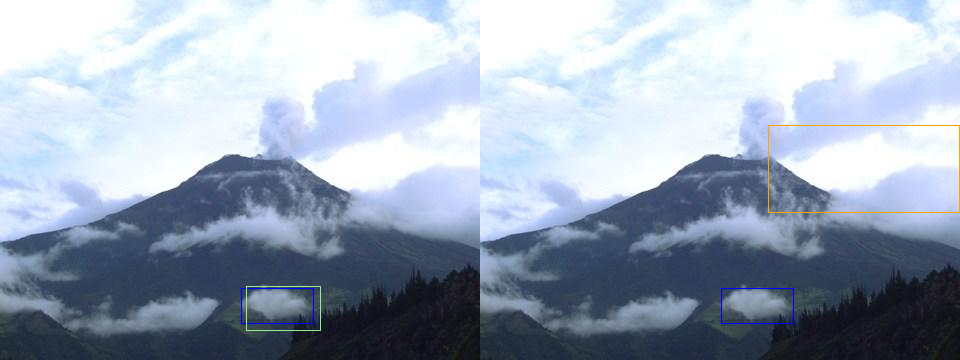

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
water near man 's back


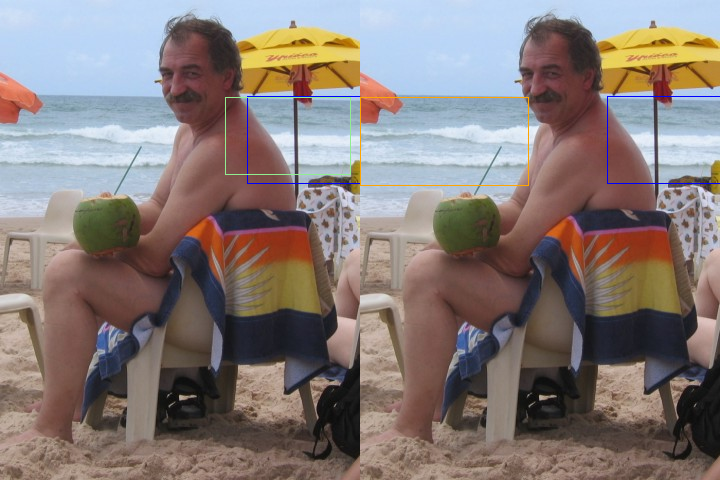

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
patch of white wall behing white hair


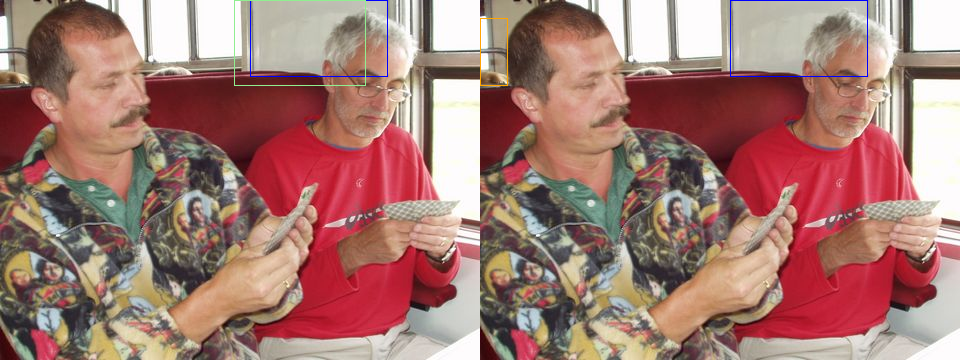

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
red and white sign above people


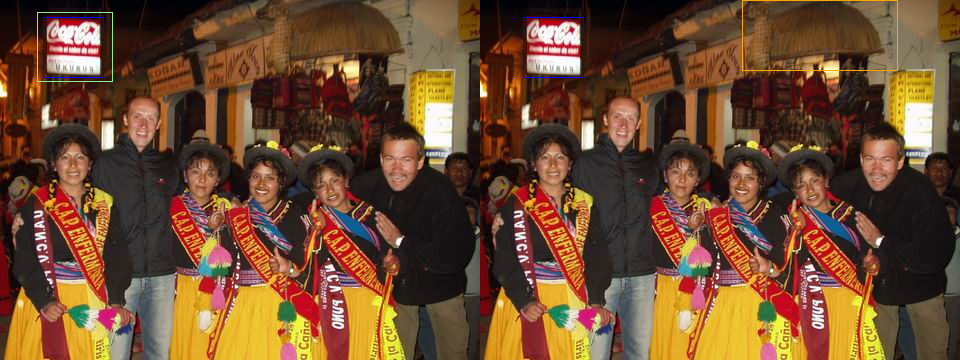

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
the face of the lady in the front row , wearing red


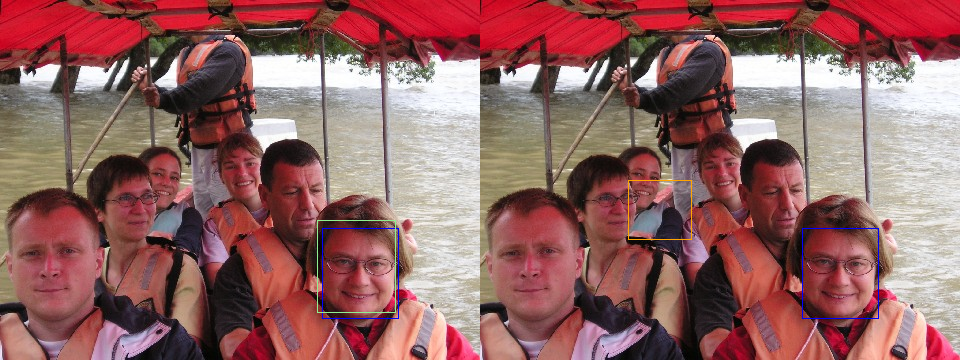

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
boy 's face above yellow hat on left


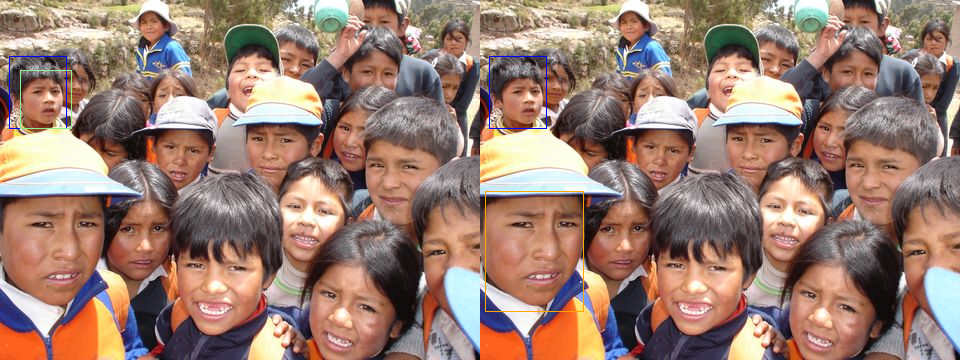

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
rock right next to his left ear


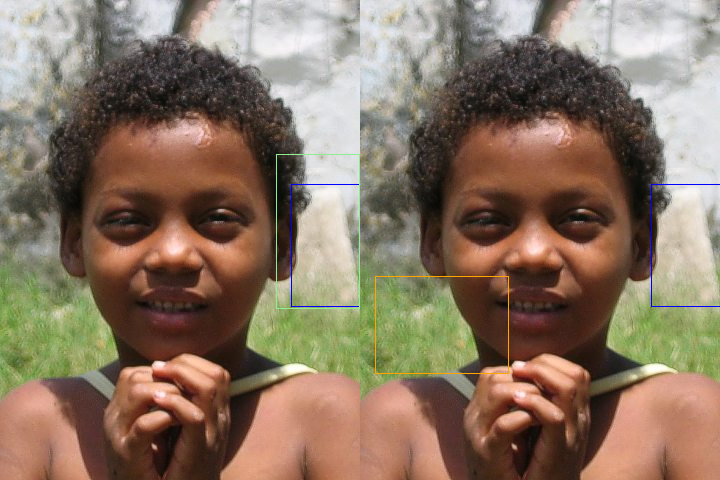

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
red seat area between people


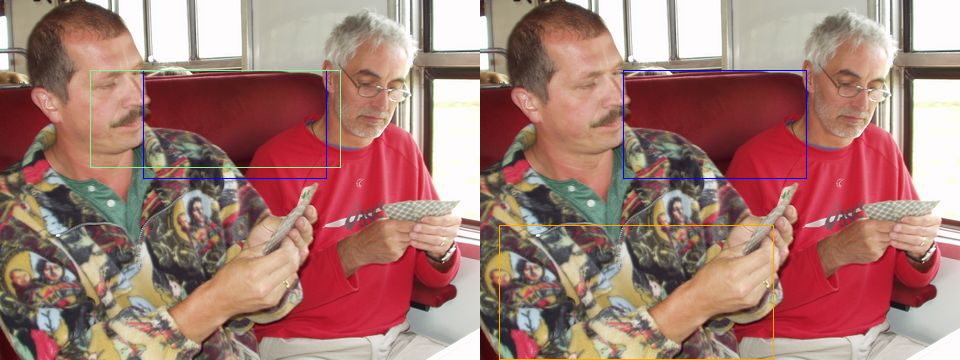

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
woman in black behind little boy


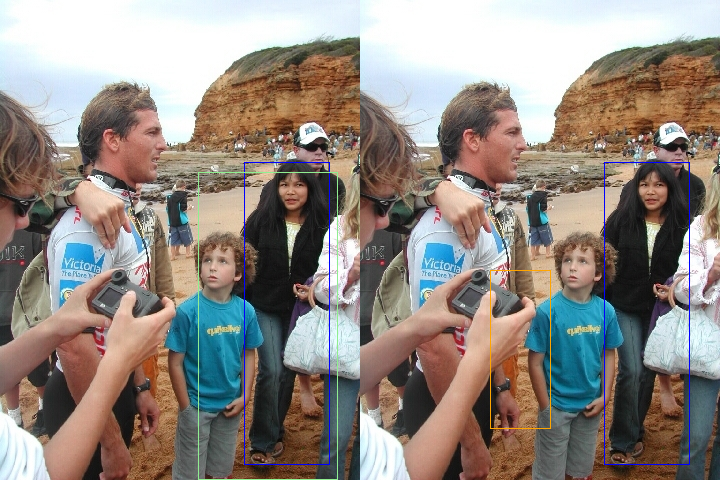

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
girl in white shirt


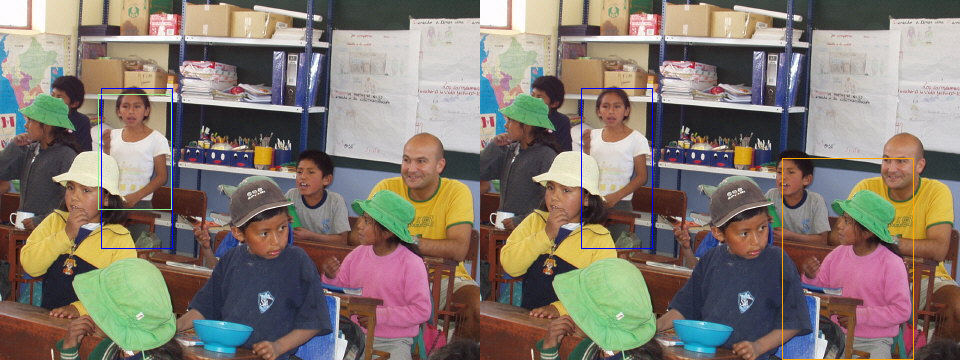

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
chair against the window blinds


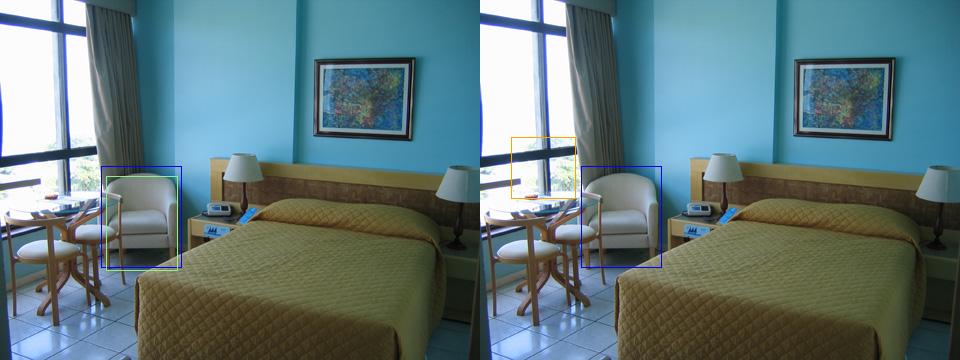

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
man in blue boxers


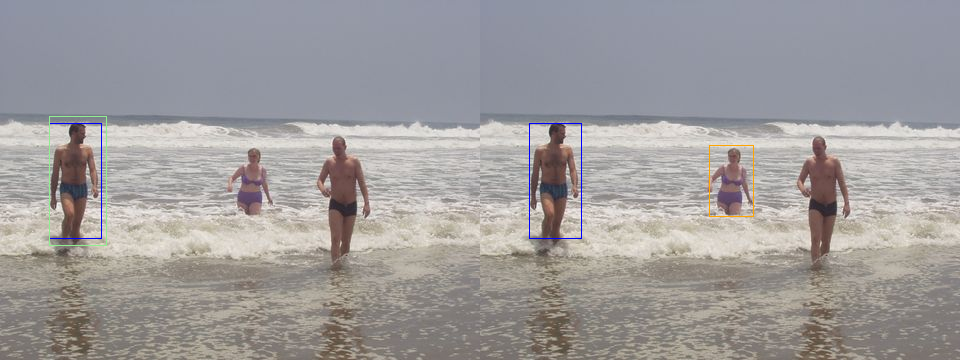

exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.
face of second person on the left


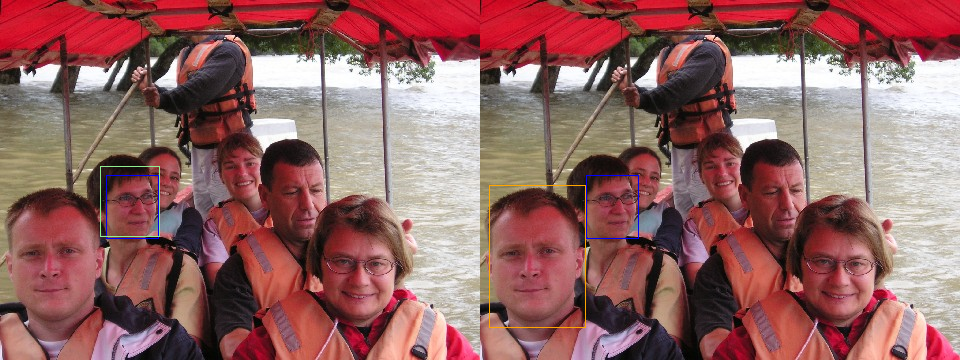

In [60]:
df_sample_cls = df_rel_22_better_than_26.query("iou_26 == 0")
for _, row in df_sample_cls.loc[:, ["bbox_raw", "bbox_pred_22", "bbox_pred_26", "img_filename", "expr"]].iterrows():
    im = Image.open(f"{BASE_PATH}{row['img_filename']}")
    im = draw_bounding_boxes(im, [row['bbox_raw']], fmt="xyxy", color="blue")
    im2 = im.copy()
    im = draw_bounding_boxes(im, [row['bbox_pred_22']], fmt="xyxy", color="lightgreen")
    im2 = draw_bounding_boxes(im2, [row['bbox_pred_26']], fmt="xyxy", color="orange")
    print(f"exp022 (left, green) and exp026 (right, orange) comparision. RELATIONAL. HITS=1.")
    print(row['expr'])
    get_concat_h(im, im2).show()